In [1]:
# import libraries
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns

In [3]:
# load iris data
iris = datasets.load_iris()

In [5]:
# convert to dataframe
x = pd.DataFrame(iris.data[:, 0:2])
y = (iris.target == 0)

In [7]:
num_sample = len(x)
print("Total no. of samples: ", num_sample)

Total no. of samples:  150


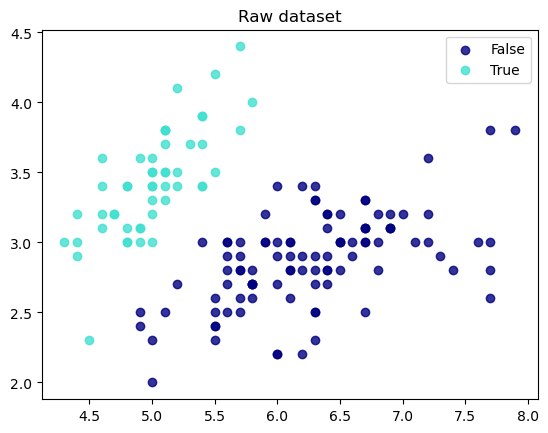

In [9]:
# data visualization
plt.figure()
colors = ['navy', 'turquoise']
for color, i, name in zip(colors, [0, 1], np.unique(y)):
    plt.scatter(x.iloc[:, 0][y == i], x.iloc[:, 1][y == i], alpha=.8, color=color, label=name)
plt.legend()
plt.title('Raw dataset')
plt.show()

In [11]:
# multivariate gaussian distribution
def multivariate_gaussian(pos, mu, Sigma):
    """ Return the multivariate Gaussian distribution on array pos.
    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # this einsim call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized way across all the input variables
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
    return np.exp(-fac / 2) / N

/opt/anaconda3/envs/p3workshop/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


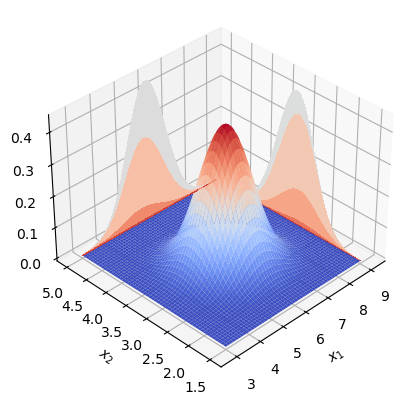

In [13]:
# our 2-dimensional distribution will be over variables X and Y
N = 160 
xx = np.linspace(3, 9, N)
yy = np.linspace(1.5, 5, N)
xx, yy = np.meshgrid(xx, yy)

# mean vector and covariance matrix
mu = np.array([np.mean(x.iloc[:, 0]), np.mean(x.iloc[:, 1])])
# calculate covariance matrix
Sigma = np.cov(x.iloc[:, 0], x.iloc[:, 1])
# pack X and Y into a single 3-dimensional array
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx
pos[:, :, 1] = yy
multivariate_gaussian(pos, mu, Sigma)

# the distribution on the variables X, Y packed into pos.
zz = multivariate_gaussian(pos, mu, Sigma)

# create a surface plot and projected filled contour plot under it
fig = plt.figure()
ax = fig.gca(projection='3d')

cset = ax.contourf(xx, yy, zz, zdir='x', offset=9, cmap=cm.coolwarm)
cset = ax.contourf(xx, yy, zz, zdir='y', offset=5, cmap=cm.coolwarm)
ax.plot_surface(xx, yy, zz, rstride=3, cstride=3, linewidth=0.1, antialiased=True, cmap=cm.coolwarm)
ax.set_zlim(0, zz.max())
ax.view_init(35, -135)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

ValueError: Argument U has a size 2 which does not match 1, the number of arrow positions

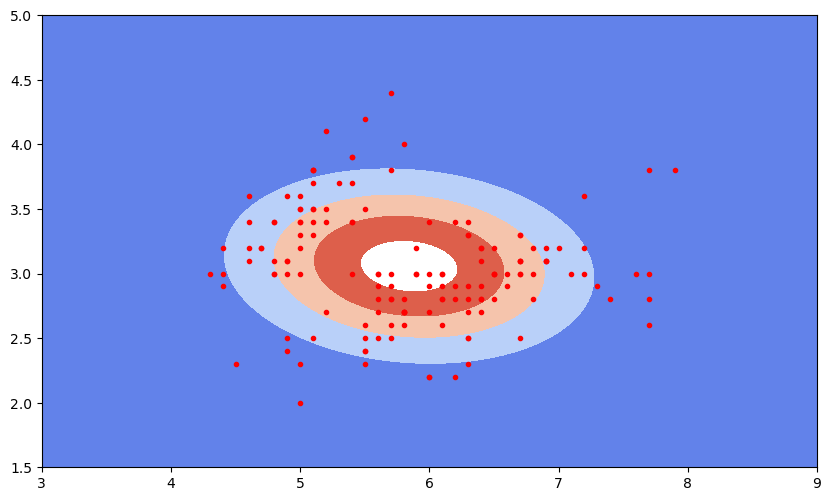

In [15]:
# calculate the covariance matrix
cov = np.cov(x.iloc[:, 0], x.iloc[:, 1])
# calculate the eigen-value and eigen-vector
eig_val, eig_vec = np.linalg.eig(cov)
# assign eigen-vecor
vec1, vec2 = eig_vec

eig_val = np.sqrt(eig_val)
# assign eigen value
val1, val2 = eig_val
levels = np.linspace(0, 0.4, 5)

fig = plt.figure(figsize = (10, 8))
ax = fig.add_subplot(111, aspect='equal')
ax.contourf(xx, yy, zz,levels = levels, cmap=cm.coolwarm)
ax.scatter(x.iloc[:, 0], x.iloc[:, 1], c = 'red', marker = '.')
ax.quiver(np.mean(x.iloc[:, 0]), np.mean(x.iloc[:, 1]), vec1*0.2, vec2*0.1, width=0.01, scale=1, color = 'k')

ax.set_xlim(3,9)
ax.set_ylim(1,5)
plt.axis('tight')
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.show()

In [17]:
# two eigen-vector which are orthogonal to each other
np.dot(vec1, vec2) 

0.0

In [19]:
model = PCA(n_components=2)
pca = model.fit_transform(x)

ValueError: Argument U has a size 2 which does not match 1, the number of arrow positions

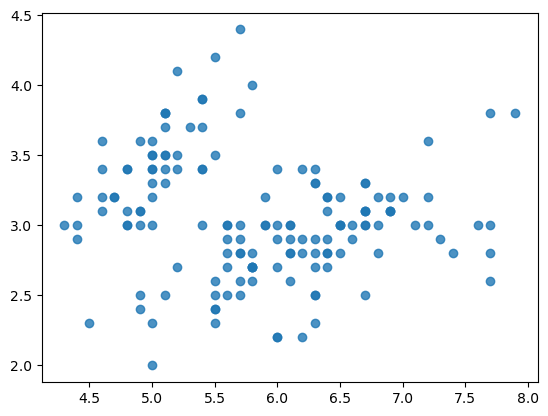

In [21]:
# plot principal components calculated by the library
axis = model.components_
axis = axis/axis.std()
x_axis, y_axis = axis
 
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], alpha=.8)
plt.quiver(np.mean(x.iloc[:, 0]), np.mean(x.iloc[:, 1]), vec2*2, vec1, width=0.01, scale=6, color = 'orange', label = 'Eigen-vectors')
plt.quiver(np.mean(x.iloc[:, 0]), np.mean(x.iloc[:, 1]), x_axis, y_axis, width=0.01, scale=6, color = 'red', label = 'PCs')
plt.title('Principal Components(n=2)')

In [23]:
# PCA for clustering
model = PCA(n_components=2).fit(x) # fit the model and apply the dimensionality reduction on X
# apply dimensionality reduction to X
pca =  model.transform(x) 

In [25]:
model.components_

array([[ 0.99640834, -0.08467831],
       [ 0.08467831,  0.99640834]])

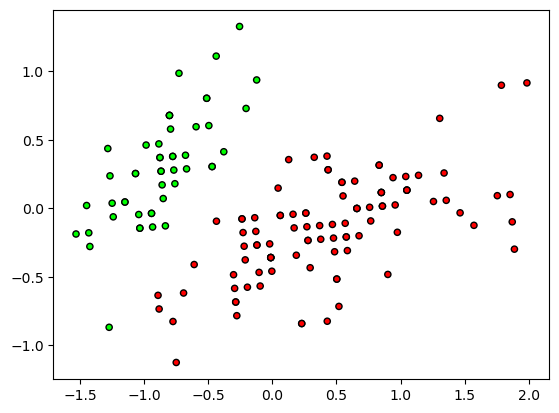

In [27]:
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
plt.scatter(pca[:, 0], pca[:, 1], c = y, cmap=cmap_bold, edgecolor = 'k', s=20)

In [29]:
# fit hard-margin linear svm to training variables and labels
hard_svc_pca = svm.LinearSVC(C = 30).fit(pca, y)
hard_svc_raw = svm.LinearSVC(C = 30).fit(x, y)
h = 0.02

/opt/anaconda3/envs/p3workshop/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


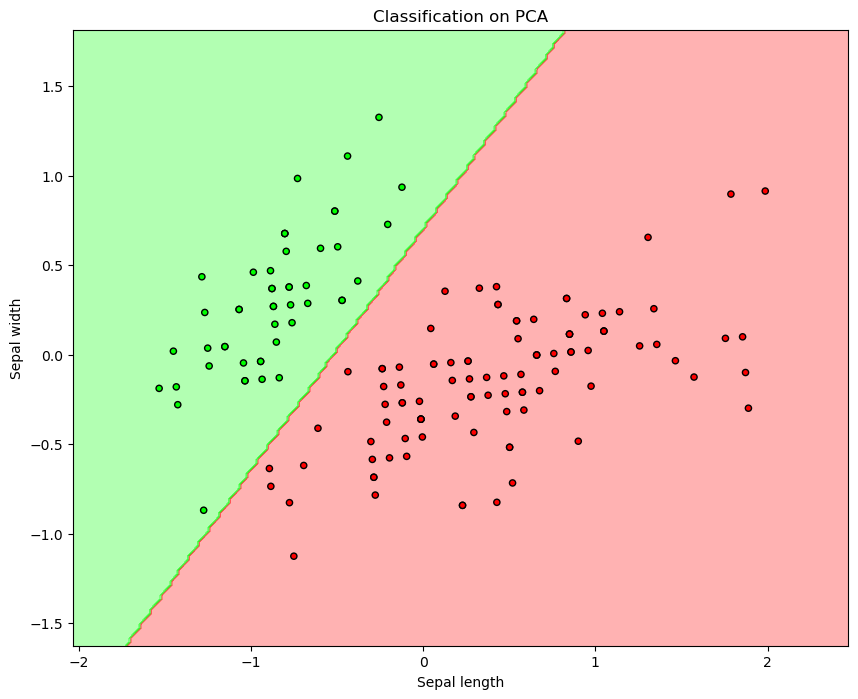

In [31]:
x_min, x_max = pca[:, 0].min() - 0.5, pca[:, 0].max() + 0.5
y_min, y_max = pca[:, 1].min() - 0.5, pca[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize = (10, 8))

# plot the decision boundary
# assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max]

Z = hard_svc_pca.predict(np.c_[xx.ravel(), yy.ravel()])

# put result in a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_bold, alpha=0.3)

# plot the training points
plt.scatter(pca[:, 0], pca[:, 1], c=y, cmap=cmap_bold, edgecolor = 'k', s=20)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Classification on PCA')

plt.show()

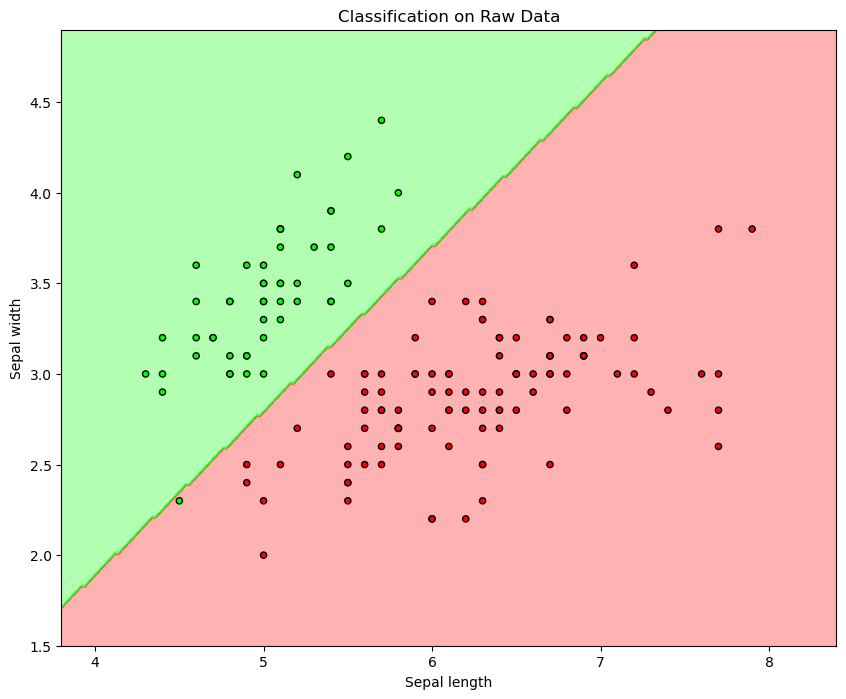

In [33]:
x_min, x_max = x.iloc[:, 0].min() - 0.5, x.iloc[:, 0].max() + 0.5
y_min, y_max = x.iloc[:, 1].min() - 0.5, x.iloc[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

plt.figure(figsize = (10, 8))

# plot the decision boundary
# assign a color to each point in the mesh [x_min, m_max]x[y_min, y_max]

Z = hard_svc_raw.predict(np.c_[xx.ravel(), yy.ravel()])

# put result in a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_bold, alpha=0.3)

# plot the training points
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=y, cmap=cmap_bold, edgecolor = 'k', s=20)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Classification on Raw Data')

plt.show()

In [35]:
print('Accuracy of SVM on PCs: ', hard_svc_pca.score(pca, y))
print('Accuracy of SVM on Raw Dataset: ', hard_svc_raw.score(x, y))

Accuracy of SVM on PCs:  1.0
Accuracy of SVM on Raw Dataset:  0.9933333333333333


In [37]:
# load iris data
iris = datasets.load_iris()
X = pd.DataFrame(iris.data)
Y = (iris.target==0)

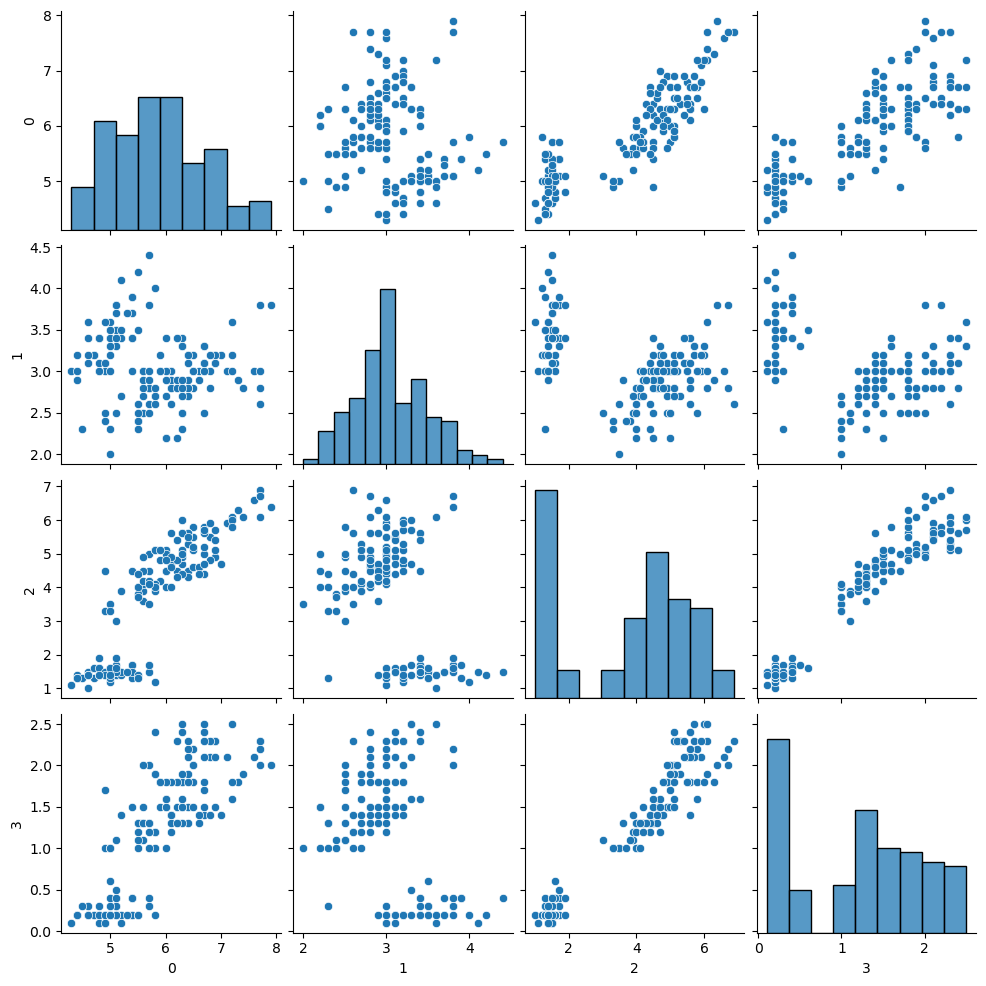

In [39]:
# check pairplot
sns.pairplot(X)

In [41]:
# PCA for all 4  features
model = PCA(n_components=4).fit(X) # fit the model and apply the dimensionality reduction on X
# apply dimensionality reduction to X
pca =  model.transform(X) 

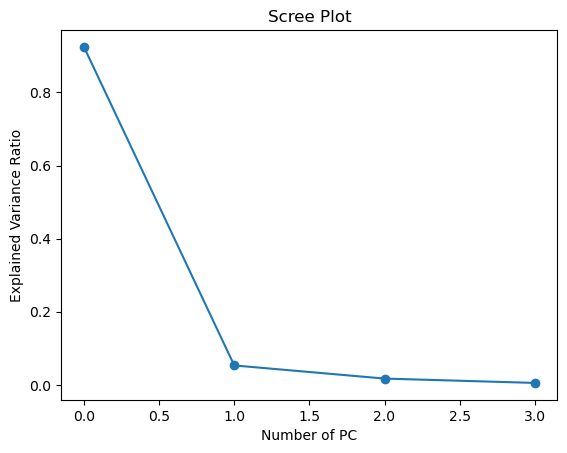

In [43]:
plt.plot(model.explained_variance_ratio_, '-o')
plt.title('Scree Plot')
plt.xlabel('Number of PC')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [45]:
model.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143],
       [-0.31548719,  0.3197231 ,  0.47983899, -0.75365743]])

In [47]:
print('Explained variance ratio: ', model.explained_variance_ratio_)

Explained variance ratio:  [0.92461872 0.05306648 0.01710261 0.00521218]
